***FCIM.FIA - Fundamentals of Artificial Intelligence***

> **Lab 4:** Learning \
> **Performed by:** Dobrojan Alexandru, FAF-212 \
> **Verified by:** Elena Graur, asist. univ.

# Theory
Linear regression is one of the most simple machine learning models capable of predicting and classifying data. Linear regression is based on the regression line or line of best fit from mathematics that finds a line that would best fit between several values with an amount of noise. In this laboratory work I need only the prediction linear regression, that evaluates the input variables in order to generate a float value, that is in my case the predicted salary of a person.

As we can see in the following example, regression line is a line that shows the approximate progression of the dependent variables, i.e. where they would fit if not noise was added to each data point. There is a regression line between dependent and independent variable only if there is a correlation between them to. The correlation measures the tendency of two variables to change together and ranges from 1 meaning perfect positive correlation to -1 meaning perfect negative correlation, 0 means there is no correlation at all and the variables grow independent of each other. The regression line can be expressed by the function $y = \alpha x + \beta$ for a single independent variable and $y = \alpha_1 x_1 + \alpha_2 x_2 + ... + \alpha_i x_i + \beta$ for an arbitrary number of independent variables.

The model does a very similar thing by finding the regression line intercept and slopes and using this function to generate results for the input variables. Below there is a very simple example of a regression line for a single independent variable:

![linear regression example](img/linear-regression.png)

## Linear regression types
There are several types of linear regression algorithms based on different formulas. Each type of linear regression has its strengths and weaknesses. In this laboratory work I used Ordinary Least Squares, Lasso and Ridge methods.

- **Ordinary least squares** (OLS) regression finds the best-fit line by minimizing the sum of squared errors SSE: $SSE = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$.
Finding the coefficients require solving the equation: $$\beta = (X^T X)^{-1} X^T y$$ for an arbitrary number of regressors, that satisfies the following objective function: $Minimize \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$
- **Lasso** regression is an optimization with a hyperparameter $\alpha$. It adds a regularization parameter to the objective function, making it $$Minimize \frac{1}{2}\sum_{i=1}^n (y_i - X_i \beta)^2 + \alpha \sum_{j=1}^p |\beta_j|$$ Where the $\alpha$ is the regularization parameter, a positive float in range [0, $\infty$)
- **Ridge** - also known as Tikhonov regularization, is a type of linear regression that includes a regularization term to prevent overfitting and improve the model's generalization to new data. Its objective function is $$Minimize \frac{1}{2}\sum_{i=1}^n (y_i - X_i \beta)^2 + \lambda \sum_{j=1}^p \beta_j^2$$

## Analyzing the dataset
After a brif analysis in Excel of the dataset, I came to the conclusion that I have to predict the TotalPay column. There are several columns in the dataset, a few of them with lots of missing data, so I have to consider that. First I notice a two string columns called EmployeeName and JobTitle. EmployeeName is redundant for the model from the beginning since it has arbitrary, non-related data which may screw up the model fitting process. JobTitle will have to be later converted to a number, it is necessary for predictions because it categorizes the row on an average salary basis. Also, I notice that the salaries are spread across different years, agencies and statuses, and they may have notes. Status if of type FT for Full-Time and PT for Part-Time.

BasePay, OvertimePay, OtherPay, Benefits, and TotalPayBenefits columns are not needed for the model because the simply provide straight  numerical values for the TotalPay, that needs to be predicted. So I will omit them in the later section.


# Practice
In this section I implement the requirements and thoroughly explain each step and each decision taken. As I stated earlier, I will implement 3 linear regression models: Ordinary Least Squares, Lasso and Ridge, because they are the most popular and basic regression models.

## Global definitions part, imports, loading the data and printing some information
In this subsection I prepare the modules, functions and data for further work with it. I use Scikit library for everything related with models since it is easy to use, open-source and very rich in community support and documentation. For plotting I use seaborn which is built over matplotlib and is intended for data science, providing additional features. Data is managed by pandas, which is the most universal tool to work with data sets.

In [239]:
# Imports section

import pandas as pd
import seaborn as sns
import numpy as np

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
# Dataset selection
from sklearn.model_selection import train_test_split
# Metrics
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

In [240]:
# Global definitions
COLUMN_TO_PREDICT = 'TotalPay'
# Size in percentage of the dataset to be split for the test, 0.15 means 15% of the dataset rows should be randomly
# chosen for testing (verifying) and 85% of the dataset is used for training the model
TEST_DATASET_SIZE = 0.15

In [241]:
# Loading the data
data = pd.read_csv('data/data.csv', low_memory=False)
# Let's have a look at the loaded data
data.head()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.0,400184.25,NaN,567595.43,567595.43,2011,NaN,San Francisco,NaN
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,538909.28,2011,NaN,San Francisco,NaN
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.6,NaN,335279.91,335279.91,2011,NaN,San Francisco,NaN
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.0,56120.71,198306.9,NaN,332343.61,332343.61,2011,NaN,San Francisco,NaN
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.6,9737.0,182234.59,NaN,326373.19,326373.19,2011,NaN,San Francisco,NaN


In [242]:
# Print the data types of each column
print(data.dtypes)

Id                    int64
EmployeeName         object
JobTitle             object
BasePay              object
OvertimePay          object
OtherPay             object
Benefits             object
TotalPay            float64
TotalPayBenefits    float64
Year                  int64
Notes               float64
Agency               object
Status               object
dtype: object


Object data type means no data type could be inferred for the column. That may happen because some values are missing or there are multiple data types present in the column, for example string, int32, float64 and so on. In my case EmployeeName and JobTitle should be strings, and in the next section I am converting the columns to string.

### Analyzing and transforming the dataset

In this subsection I analyze each column in order to determine whether to pick it or no. Also I transform the data where it is required.

In [243]:
# Convert object data types to string
data['EmployeeName'] = data['EmployeeName'].astype('string')
data['JobTitle'] = data['JobTitle'].astype('string')
print(data.dtypes)

Id                           int64
EmployeeName        string[python]
JobTitle            string[python]
BasePay                     object
OvertimePay                 object
OtherPay                    object
Benefits                    object
TotalPay                   float64
TotalPayBenefits           float64
Year                         int64
Notes                      float64
Agency                      object
Status                      object
dtype: object


Next, a very important step is looking for columns with missing data, it can be 0 or NaN, in my case it is NaN. There is how I print the column names that have at least one NaN value in them:

In [244]:
# See what columns have rows with missing data
print(data.columns[data.isna().any()].values)

['BasePay' 'Benefits' 'Notes' 'Status']


In [245]:
print(data.dtypes)


Id                           int64
EmployeeName        string[python]
JobTitle            string[python]
BasePay                     object
OvertimePay                 object
OtherPay                    object
Benefits                    object
TotalPay                   float64
TotalPayBenefits           float64
Year                         int64
Notes                      float64
Agency                      object
Status                      object
dtype: object


Now the data types are more consistent. Next, I look at unique values in the following columns, because there were empty cells in the dataset or there were only one values when I looked at the raw dataset. I use the *unique* function of pandas to show the unique values:

In [246]:
# See if these columns have more than a single value
for column in ['Year', 'Notes', 'Agency', 'Status']:
    print(f"{column}: {data[column].unique()}")

Year: [2011 2012 2013 2014]
Notes: [nan]
Agency: ['San Francisco']
Status: [nan 'PT' 'FT']


As I noticed, Notes and Agency can be removed since they have only one value, that makes them useless. We have several values in Year, thus I leave it. Also the Status column has NaN values in it, that means I have to either populate NaN values or get rid of the whole column, because the lack of values will affect the predictions precision.

In [247]:
cols_to_remove = ['EmployeeName', 'BasePay', 'OvertimePay', 'OtherPay', 'Benefits', 'TotalPayBenefits', 'Notes',
                  'Agency', 'Status']
data = data.drop(cols_to_remove, axis='columns')
data.head()

,Id,JobTitle,TotalPay,Year
0,1,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,567595.43,2011
1,2,CAPTAIN III (POLICE DEPARTMENT),538909.28,2011
2,3,CAPTAIN III (POLICE DEPARTMENT),335279.91,2011
3,4,WIRE ROPE CABLE MAINTENANCE MECHANIC,332343.61,2011
4,5,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",326373.19,2011


Next, I have to get rid of the string column, because the linear regression works only with numbers, so I have to replace each string with a number. I chose to factorize each title into a number that would act as an ID, below I show how:

In [248]:
# Replace (factorize) Job titles from string to integers, for example [a, b, c, a, b] -> [0, 1, 2, 0, 1]
data['JobTitle'], _ = pd.factorize(data['JobTitle'])
data.head()

,Id,JobTitle,TotalPay,Year
0,1,0,567595.43,2011
1,2,1,538909.28,2011
2,3,1,335279.91,2011
3,4,2,332343.61,2011
4,5,3,326373.19,2011


After I factorized the JobTitle column, I look at the correlations between the independent variables and the target variable. Pandas has a useful function for automating this process called corr:

In [249]:
# Show correlations with remaining columns
data.corr()[COLUMN_TO_PREDICT]

Id         -0.211478
JobTitle   -0.350263
TotalPay    1.000000
Year        0.032090
Name: TotalPay, dtype: float64

The correlation with year is minimal, meaning they are almost independent of each other. JobTitle correlation is irrelevant since it factorized from string.

<Axes: xlabel='JobTitle', ylabel='TotalPay'>

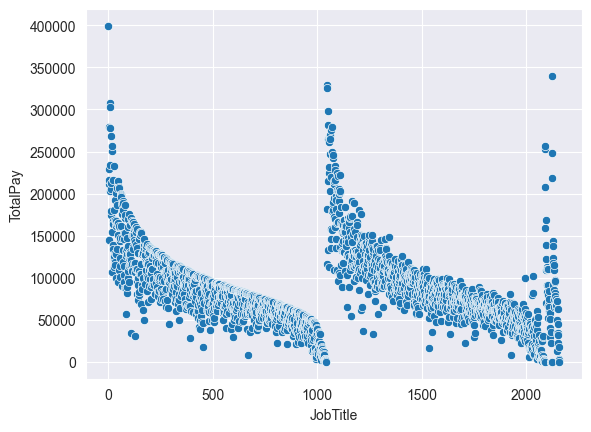

In [250]:
# Plot the average TotalPay per JobTitle, group by 'JobTitle' and calculate the mean of 'TotalPay'
sns.scatterplot(x='JobTitle', y='TotalPay', data=data.groupby('JobTitle')['TotalPay'].mean().reset_index())

<Axes: xlabel='TotalPay', ylabel='Year'>

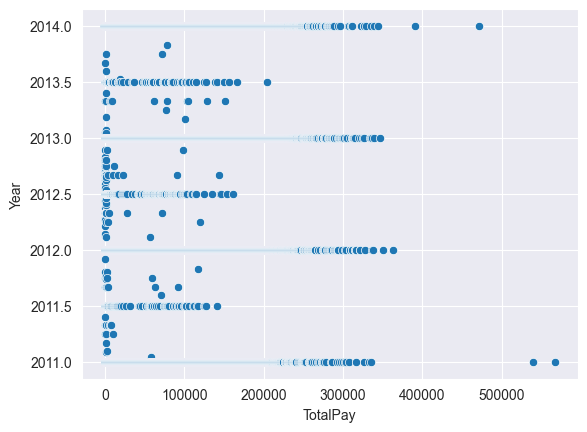

In [251]:
# Plot the average Year based on TotalPay, group by 'TotalPay' and calculate the mean of 'Year'
sns.scatterplot(x='TotalPay', y='Year', data=data.groupby('TotalPay')['Year'].mean().reset_index())

## Training the models
In this subsection I define the models, set up the data to train them and perform the fitting phase. First, I divide the dataset into the training and the testing part on a random basis. Scikit has a useful function for this called train_test_split:

In [252]:
# Divide data into train and test sets
X = data.drop(COLUMN_TO_PREDICT, axis='columns')
y = data[COLUMN_TO_PREDICT]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_DATASET_SIZE)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(126355, 3) (126355,)
(22299, 3) (22299,)


Next, I initialize the models from the library and train them with the dataset from above:

In [253]:
least_squares_regression = LinearRegression()
lasso_regression = Lasso(alpha=5)  # default 1
ridge_regression = Ridge(alpha=5)  # default 1

predictors = X_train.columns
# Train the model
least_squares_regression.fit(X_train[predictors], y_train)
lasso_regression.fit(X_train[predictors], y_train)
ridge_regression.fit(X_train[predictors], y_train)

Ridge(alpha=5)

## Predicting
After the models are trained, I can proceed to predicting the variables, I use the test dataset for that. Since all the models were trained on the same dataset in order to make sure that is the same data, I can directly further compare the predicted values using metrics. Scikit has a simple function called predict for generating a series of predictions based on input variables:

In [254]:
least_squares_y_pred = least_squares_regression.predict(X_test)
least_squares_y_pred

array([102858.81695849,  81250.55714476,  18375.16097432, ...,
        12414.95450711,  -2941.94793481,  86656.43131351])

In [255]:
lasso_y_pred = lasso_regression.predict(X_test)
lasso_y_pred

array([102860.82338893,  81239.99299496,  18408.1108706 , ...,
        12428.97901273,  -2920.60166377,  86645.38395005])

In [256]:
ridge_y_pred = ridge_regression.predict(X_test)
ridge_y_pred

array([102861.53432256,  81236.32731241,  18419.47085011, ...,
        12433.77353501,  -2913.27160442,  86641.577874  ])

Now when we have the predictions for all three models, I can merge them together in a dataframe and show it.

In [257]:
merged_df = X_test.copy()
merged_df['Predicted (Least Squares)'] = least_squares_y_pred
merged_df['Predicted (Lasso)'] = lasso_y_pred
merged_df['Predicted (Ridge)'] = ridge_y_pred
merged_df['Actual'] = y_test
merged_df.head()

,Id,JobTitle,Year,Predicted (Least Squares),Predicted (Lasso),Predicted (Ridge),Actual
11326,11327,167,2011,102858.816958,102860.823389,102861.534323,91436.82
52911,52912,1744,2012,81250.557145,81239.992995,81236.327312,73834.55
29902,29903,449,2011,18375.160974,18408.110871,18419.470850,16905.40
106554,106555,1549,2013,9769.221662,9792.309173,9800.257591,8215.79
41402,41403,1196,2012,134541.802357,134517.057062,134508.526959,132367.28


I noticed that the predictions precision vary significantly, for example there are relatively precise predictions like 66k for 62k actual, but also are very far from the actual value like 80k for 8k actual. Next I gain more insights about the precision using metrics.

## Metrics
I am going to use several metrics for evaluating the models. They are: Mean Absolute Error (MAE), Root Mean Square Error (RMSE) and $R^2$ score with the according formulas:
$$MAE = \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y_i}|$$ which is basically the average error, the most simple error metric.
$$RMSE = \frac{1}{n} \sqrt{\sum_{i=i}^n (y_i - \hat{y_i})^2}$$ which is a more advanced error metric, it is sensible to outliers as opposed to MAE, thus will be higher if the predicted values have outliers from the actual value.
$$R^2 = \frac{SS_{res}}{SS_{tot}}$$ is a score about how effective is the prediction in comparison to just using the mean value of y. $R^2 \in [0, 1]$. $SS_{res}$ is the sum of residuals (errors), also called the Residual Sum of Squares (RSS), $SS_{res} = \sum_{i=1}^n (y_i - \hat{y})$. $SS_{tot}$ is also known as Total Sum of Squares (TSS). $SS_{tot} = \sum_{i=1}^n (y_i - \bar{y_i})$. $R^2$ is also called the Coefficient of Determination and is a good metric for determining that the value of the predictors really matter when predicting.

In [258]:
least_squares_mae = mean_absolute_error(y_test, least_squares_y_pred)
lasso_mae = mean_absolute_error(y_test, lasso_y_pred)
ridge_mae = mean_absolute_error(y_test, ridge_y_pred)
print(f'Least Squares MAE: {least_squares_mae:.2f}')
print(f'Lasso MAE: {lasso_mae:.2f}')
print(f'Ridge MAE: {ridge_mae:.2f}')

Least Squares MAE: 7662.92
Lasso MAE: 7657.75
Ridge MAE: 7655.98


In [259]:
least_squares_rmse = root_mean_squared_error(y_test, least_squares_y_pred)
lasso_rmse = root_mean_squared_error(y_test, lasso_y_pred)
ridge_rmse = root_mean_squared_error(y_test, ridge_y_pred)
print(f'Least Squares RMSE: {least_squares_rmse:.2f}')
print(f'Lasso RMSE: {lasso_rmse:.2f}')
print(f'Ridge RMSE: {ridge_rmse:.2f}')

Least Squares RMSE: 12084.17
Lasso RMSE: 12084.02
Ridge RMSE: 12083.97


Root Mean Square Error is higher than the Mean Absolute Error, meaning there are significant outliers in the predicted values, it is one of the best metrics for linear regression models due to that.

In [260]:
least_squares_r2 = r2_score(y_test, least_squares_y_pred)
lasso_r2 = r2_score(y_test, lasso_y_pred)
ridge_r2 = r2_score(y_test, ridge_y_pred)
print(f'Least Squares R2: {least_squares_r2:.3f}')
print(f'Lasso R2: {lasso_r2:.3f}')
print(f'Ridge R2: {ridge_r2:.3f}')

Least Squares R2: 0.942
Lasso R2: 0.942
Ridge R2: 0.942


Not a huge score, it means the models predicts ~24% more accurate than simply using the average actual values from the train set.

# Conclusions

